# Brief Analysis of the Variation

This notebook produces the upper part of the first table.

We compute how much, on average, token $t+i$ impacts token $t$, for $i=1, \dots, T$.
Variation is computed by the cosine distance to the state of token t in the previous time step (i.e. the diagonal $-i$ in the chart).

We use only the last layer, as that is mainly what is supposed to be used for subsequent predictions.

We only look at the unambiguous stimuli, to have numbers on more "standard" sentences and then compare to the ambiguous cases in the end.

In [1]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import paired_distances
from tqdm import tqdm

from incstates import IncStatesAnalyser
from utils import METRIC

/tmp/ipykernel_2092680/2213993791.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/users/blasota/anaconda3/envs/restart-inc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL = 'bert'
SELECTED_LAYER = 12
T = 10
REFERENCE = 'previous'

TRIANGLES_PATH = './outputs/triangles/'
STATES_PATH = './outputs/embeddings/'
DATA_PATH = './outputs/preprocessed_stimuli.csv'

SOURCES = ['nnc', 'classic-nps', 'classic-mvrr']

In [3]:
data_df = pd.read_csv(DATA_PATH, index_col=0)

In [4]:
def dist_func(*x):
    """Return a specific distance function between two vectors."""
    return paired_distances(*x, metric=METRIC) 


def get_objects(sentence_type):
    objs = {}
    for source in SOURCES:

        with h5py.File(Path(f'{STATES_PATH}{MODEL}_{source}_embeddings.h5'), 'r') as f:
            prisms = {key: value[:] for key, value in f.items()}

        with h5py.File(Path(f'{TRIANGLES_PATH}{MODEL}_{source}_{METRIC}.h5'), 'r') as f:
            triangles = {key: value[:] for key, value in f.items()}
        
        source_df = data_df[data_df.source == source]
        objs[source] = {}

        for key, states in tqdm(prisms.items(), desc=source):
            if key.split('_')[1] != sentence_type:
                continue

            sentence = source_df.loc[int(key.split('_')[0])].stimulus

            obj_stimulus = IncStatesAnalyser(sentence,
                                             states=states,
                                             tokenized=True)
            obj_stimulus.inc_charts = {REFERENCE: triangles[f'{key}_{REFERENCE}']}
            objs[source][key] = obj_stimulus

    return objs

## Variation on unambiguous sentences

Create the objects with the triangular charts filled with the distance to the previous state:

In [5]:
objs = get_objects(sentence_type='baseline')

classic-mvrr: 100%|██████████| 40/40 [00:00<00:00, 16315.49it/s]


In [6]:
changes_df = pd.DataFrame(columns=['source', 't', 'value'])

for source, states_dic in objs.items():
    for obj in states_dic.values():
        
        chart = obj.inc_charts[REFERENCE][SELECTED_LAYER]
        for t in range(1, T+1):
            diag_vars = chart.diagonal(-t)
            for value in diag_vars:
                changes_df.loc[len(changes_df.index)] = [source, t, value]

In [7]:
table = changes_df.groupby(['source', 't']).mean().reset_index().pivot_table(columns='t', index='source').droplevel(0, axis=1)
table

t,1,2,3,4,5,6,7,8,9,10
source,,,,,,,,,,
classic-mvrr,0.380707,0.090510,0.050699,0.039913,0.035920,0.030198,0.028787,0.026716,0.022102,0.019006
classic-nps,0.386543,0.098241,0.066038,0.046451,0.034889,0.026420,0.020836,0.018464,0.017144,0.017576
nnc,0.342691,0.115953,0.151056,0.130156,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(table.to_latex(float_format="%.2f", na_rep='-', columns=[1,2,3,4,5,6,7]))

\begin{tabular}{lrrrrrrr}
\toprule
t & 1 & 2 & 3 & 4 & 5 & 6 & 7 \\
source &  &  &  &  &  &  &  \\
\midrule
classic-mvrr & 0.38 & 0.09 & 0.05 & 0.04 & 0.04 & 0.03 & 0.03 \\
classic-nps & 0.39 & 0.10 & 0.07 & 0.05 & 0.03 & 0.03 & 0.02 \\
nnc & 0.34 & 0.12 & 0.15 & 0.13 & - & - & - \\
\bottomrule
\end{tabular}



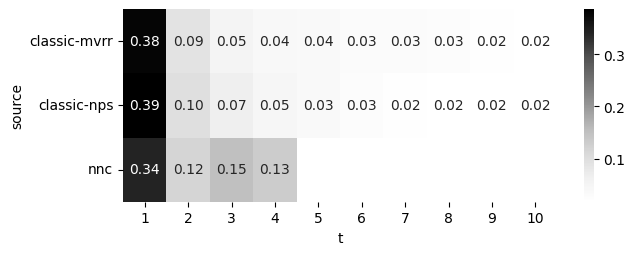

In [9]:
fig, ax = plt.subplots(figsize=(7, 2.5))
sns.heatmap(table, annot=True, fmt='.2f', cmap='Greys', ax=ax)
plt.yticks(rotation=0)
plt.show()

## Variation on ambiguous token when disambigating token is observed

Now we use the ambiguous stimuli to compute the average change that occurs on the ambiguous token(s) when the disambiguating token/region is integrated.

For the classic cases, two options. Here, we look at what happens at the first verb when one token after the first disambiguating token is obverved. This makes sense, because only the first disambiguating token may not be enough for the model to construct a valid interpretation.

In [10]:
objs = get_objects(sentence_type='stimulus')

variations = []

for source, states_dic in objs.items():
    source_df = data_df[data_df.source == source]
    for key, obj in states_dic.items():
        
        idx = int(key.split('_')[0])
        ambiguous_token = source_df.loc[idx].amb_position_ambiguous
        disambiguating = source_df.loc[idx].disamb_position_ambiguous

        if source in ('classic-nps', 'classic-mvrr'):
            # we look at one token after the verb, because there seems to be a
            # delay of one step in understanding that the second verb disambiguates
            disambiguating = int(disambiguating) + 1

            # add +1 or +2 to the ambiguous token position to consider the det and noun
            # as the ambiguous token, respectively
            # ambiguous_token = int(ambiguous_token) + 2

        variation = obj.inc_charts[REFERENCE][SELECTED_LAYER][int(disambiguating)][int(ambiguous_token)]
        variations.append((source, variation))

classic-mvrr: 100%|██████████| 40/40 [00:00<00:00, 19341.96it/s]


In [11]:
df = pd.DataFrame(variations, columns=['source', 'value'])

table = df.groupby(['source']).mean()
table

,value
source,
classic-mvrr,0.146475
classic-nps,0.157802
nnc,0.409570
